# YOLO V1

- Step 1: Split image into SxS grids of equal size.
  - Each cell will output a prediction with a corresponding bounding box.
- Step 2: Find one cell responsible for predicting one object. The one cell thats responsible is the one that contains the object's center.
  - Each **output** and **label** will be **relative** to the cell!
  - Each bounding box for each cell will have: `[x,y,w,h]`


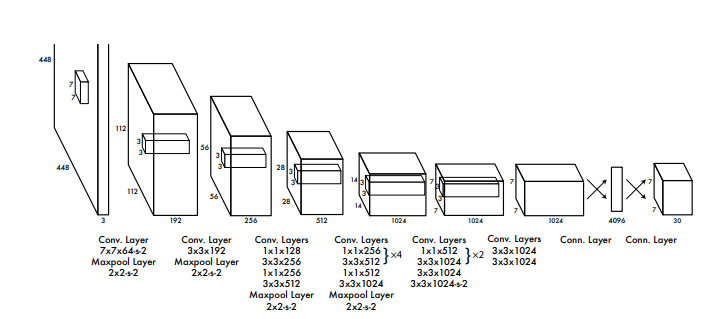

In [1]:
import torch
import torch.nn as nn

In [2]:
# Architecture including convolution layer exclusing fully connected layer
architecture_config = [
    # Each tuple: Kernel_size, output_channels, stride, padding
    (7, 64, 2, 3), # 448 --> 224
    "M", # Max pooling 2x2 of stride 2 (224--> 112)
    (3, 192, 1, 1), # 112 --> 112
    "M", # 112 --> 56
    (1, 128, 1, 0), # 56 --> 56
    (3, 256, 1, 1), # 56 --> 56
    (1, 256, 1, 0), # 56 --> 56
    (3, 512, 1, 1), # 56 --> 56
    "M", # 56 --> 28
    [(1, 256, 1, 0), (3, 512, 1, 1), 4], # Repeat these two conv layer 4 times (28 --> 28)
    (1, 512, 1, 0), # 28 --> 28
    (3, 1024, 1, 1), # 28 --> 28
    "M", # 28 --> 14
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2], # Repeat these two conv layer 2 times (14 --> 14)
    (3, 1024, 1, 1), # 14 --> 14
    (3, 1024, 2, 1), # 14 --> 7 (7x7x1024)
    (3, 1024, 1, 1), # 7 --> 7
    (3, 1024, 1, 1), # 7 --> 7 (7x7x1024)
]

In [3]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
class Yolov1(nn.Module):
  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1, self).__init__()

    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)

  def forward(self, x):
    x = self.darknet(x)
    return self.fcs(torch.flatten(x, start_dim=1)) # Dimension to flatten is WxHxC, not the batch size so start_dim=1

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers += [CNNBlock(in_channels,
                           out_channels=x[1],
                           kernel_size=x[0],
                           stride=x[2],
                           padding=x[3])]

        in_channels = x[1] # Update the in_channels

      elif type(x) == str:
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

      elif type(x) == list:
        conv1 = x[0] # Tuple
        conv2 = x[1] # Tuple
        num_repeats = x[2] # Integer

        for _ in range(num_repeats):
          layers += [CNNBlock(in_channels,
                              out_channels = conv1[1],
                              kernel_size = conv1[0],
                              stride = conv1[2],
                              padding = conv1[3])]

          layers += [CNNBlock(in_channels = conv1[1], # Since the out_channels of conv1 is going to be the in_channels of conv2
                              out_channels = conv2[1],
                              kernel_size = conv2[0],
                              stride = conv2[2],
                              padding = conv2[3])]

          in_channels = conv2[1] # Update in_channels

    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024*S*S, 4096),
        nn.Dropout(0.0),
        nn.LeakyReLU(0.1),
        nn.Linear(4096, S*S*(C+B*5)) # (S, S, 30) where C+B*5 = 30
    )


In [5]:
# Testing the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
x = torch.randn((2,3,448,448))
print(model(x).shape)

torch.Size([2, 1470])


# Intersection Over Union

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  """
  Calculates intersection over union

  Parameters:
    boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
    boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
    box_format (str): midpoint/ corners, if boxes (x,y,w,h) or (x1, y1, x2, y2)

  Returns:
    tensor: Intersection over union for all examples

  Note:
    The `...` is used for indexing all elements in the preceding dimensions
    and `0:1` represents the range of indices to extract along the last dimension
  """

  if box_format == 'midpoint':
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  elif box_format == 'corners':
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4] # Slicing this way to maintain the shape i.e (N,1) where, N is the number of bboxes

    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.max(box1_x2, box2_x2)
  y2 = torch.max(box1_y2, box2_y2)

  # .clamp(0) is for the case when they do not intersect
  intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0) # length * breadth

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1)) # Absolute so that area is not negative
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1)) # Absolute so that area is not negative

  # IOU = Area of intersection / Area of Union
  return intersection / (box1_area + box2_area - intersection + 1e-6)


# Non Max Supression Algorithm
- Step 1: Start with discarding all bounding boxes < probability threshold
- Step 2: Select the Bounding Box with the largest probability / score
- Step 3: Remove all the other bounding boxes with IoU > threshold

**Note**: Do for each class

In [7]:
def non_max_supression(bboxes, iou_threshold, threshold, box_format="corners"):
  """
  Note: bboxes input should be list of bounding boxes
  i.e bboxes = [[1, 0.9, x1, y1, x2, y2], ..] # Each bounding box --> [class, probability, x1, y1, x2, y2]

  """

  # Validate the input
  assert type(bboxes) == list

  # Discard all the bounding box < probability threshold
  bboxes = [box for box in bboxes if box[1] > threshold]

  # Sort the bboxes in descending order based on their probabilities
  bboxes = sorted(bboxes, key=lambda x:x[1], reverse=True)

  # Create empty list for bboxes to append after NMS
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0) # Select and remove the bounding box with largest probability from bboxes list

    # New list comprehension for different class or same class having IoU less than threshold
    bboxes = [
        box
        for box in bboxes
        if box[0] != chosen_box[0] # Checks if the class label of box is different from the class label of chosen_box
        or intersection_over_union(
            torch.tensor(chosen_box[2:]),
            torch.tensor(box[2:]),
            box_format = box_format,
        ) < iou_threshold # Checks if IoU < iou_threshold
    ]

    bboxes_after_nms.append(chosen_box)

  return bboxes_after_nms

# Mean Average Precision

- Step 1:  Get all bounding box predictions on our test set
- Step 2: Sort by **descending confidence score**
- Step 3: Calculate the **Precision** and **Recall** as we go through all outputs
- Step 4: Plot the **Precision-Recall graph**
- Step 5: Calculate Area under **Precision-Recall graph** which is the **average precision** for one class.
- Step 6: Similarly calculate **average precision** for all the other class
- Step 7: Calculate **mAP** i.e sum of all the average pecisions of all the classes / number of classes

Finally, all this was calculated given **specific IoU** threshold of 0.5, we need to redo all computations for many IoUs, example: 0.5, 0.55, 0.6, ..., 0.95. Then **average this** and this will be our **final result**. This is what is meant by mAP@0.5:0.005:0.95 (mAP at 0.5 with a step size of 0.05 upto 0.95).

In [8]:
import torch
from collections import Counter

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='midpoint', num_classes=20):
  """
  Note: pred_boxes input should be list of bounding boxes
  i.e pred_boxes = [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]

  Similarly for true_boxes
  """

  average_precisions = [] # To store average precisions of each class
  epsilon = 1e-6 # For numerical stability

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    # Calculate the count of unique elements in the ground_truths list and stores the result in the amount_bboxes variable
    # For eg. img 0 has 3 bboxes, img 1 has 5 bboxes then, amount_bboxes = {0:3, 1:5}
    amount_bboxes = Counter([gt[0] for gt in ground_truths])

    for key, val in amount_bboxes.items():
      amount_bboxes[key] = torch.zeros(val)
    # amount_boxes = {0: torch.tensor([0,0,0]), 1: torch.tensor([0,0,0,0,0])}

    # Sort the bboxes in descending order based on their probabilities
    detections.sort(key=lambda x: x[2], reverse=True)

    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    # If none exists for this class then we can safely skip
    if total_true_bboxes == 0:
      continue

    for detection_idx, detection in enumerate(detections):
      # Only filter images having same index
      ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

      num_gts = len(ground_truth_img)
      best_iou = 0

      # For selection of bbox having highest iou
      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.tensor(detection[3:]),
            torch.tensor(gt[3:]),
            box_format = box_format
        )

        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      # Categorizing either TP or FP
      if best_iou > iou_threshold:
        # Check if we haven't covered this bounding box before | '0' means we haven't covered
        if amount_bboxes[detection[0]][best_gt_idx] == 0:
          TP[detection_idx] = 1
          amount_bboxes[detection[0]][best_gt_idx] == 1 # Update that now it's covered
        else:
          FP[detection_idx] = 1
      else:
        FP[detection_idx] = 1

    # [1,1,0,1,0] --> [1,2,2,3,3]
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)

    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))

    # By adding these initial values of 1 to precisions and 0 to recalls,
    # the code ensures that the precision and recall values start with the appropriate initial points.
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))

    # Calculate the average precision by using the trapezoidal rule to compute the area under the precision-recall curve
    average_precisions.append(torch.trapz(precisions, recalls))

  # Return mAP
  return sum(average_precisions) / len(average_precisions)


Note: amount_bboxes is done to keep track of the target boounding boxes that we have covered so far. We can't have mutiple prediction bounding boxes for one target bounding box and count them all as correct. Only the first one that covers a target bounding box is correct and the other ones would be false positives.

# Loss Function
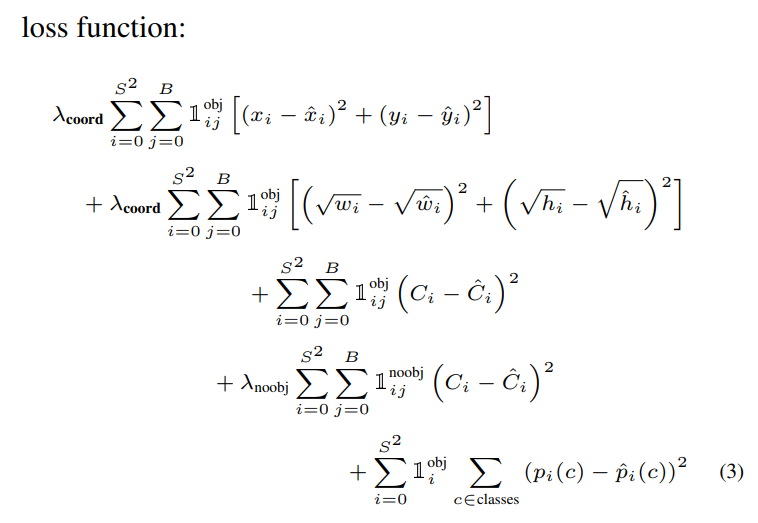

In [9]:
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum") # reduction="sum" indicates that the losses will be summed up
    self.S = S
    self.B = B
    self.C = C

    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])

    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
    iou_maxes, bestbox = torch.max(ious, dim=0) # Store the maximum values and corresponding indices, respectively

    # Get the confidence probability and unsqueeze in 3rd dim
    exists_box = target[..., 20].unsqueeze(3) # Tells us if there is an object in cell (i)

    #=======================#
    # FOR BOUNDING BOX LOSS #
    #=======================#
    box_predictions = exists_box * (
        (
          bestbox * predictions[..., 26:30] # if second bbox is the best
          + (1 - bestbox) * predictions[..., 21:25] # if first bbox is the best
        )
    )

    box_targets = exists_box * target[..., 21:25]

    # Taking square root of width and height as required
    box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4]) * torch.sqrt(
        torch.abs(box_predictions[...,2:4] + 1e-6))
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    # Calculate the loss
    # end_dim=-2 indicates that all dimensions except the last two should be flattened because (N,S,S,4) --> (N*S*S, 4)
    box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2))

    #=================#
    # FOR OBJECT LOSS #
    #=================#
    pred_box = (
        bestbox*predictions[..., 25:26] # if second box is best, take its confidence value
        + (1-bestbox)*predictions[..., 20:21] # if first box is best, take its confidence value
    )

    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,20:21])
    )

    #====================#
    # FOR NO OBJECT LOSS #
    #====================#

    # For first bbox
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * predictions[...,20:21], start_dim=1), # (N,S,S,1) --> (N, S*S*1)
        torch.flatten((1 - exists_box) * target[...,20:21], start_dim=1)
    )

    # For second bbox
    no_object_loss += self.mse(
        torch.flatten((1 - exists_box) * predictions[...,25:26], start_dim=1),
        torch.flatten((1 - exists_box) * target[...,20:21], start_dim=1)
    )

    #================#
    # FOR CLASS LOSS #
    #================#
    class_loss = self.mse(
        torch.flatten(exists_box * predictions[..., :20], end_dim=-2), # (N,S,S,20)-->(N*S*S, 20)
        torch.flatten(exists_box * target[..., :20], end_dim=-2)
    )

    # ACTUAL LOSS
    loss = (
        self.lambda_coord * box_loss
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# Plot image

In [10]:
img_labels = {0:'aeroplane',
              1:'bicycle',
              2:'bird',
              3:'boat',
              4:'bottle',
              5:'bus',
              6:'car',
              7:'cat',
              8:'chair',
              9:'cow',
              10:'diningtable',
              11:'dog',
              12:'horse',
              13:'motorbike',
              14:'person',
              15:'pottedplant',
              16:'sheep',
              17:'sofa',
              18:'train',
              19:'tvmonitor'}

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    # Convert input image to numpy array
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        cls = int(box[0])
        prob = box[1]
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # Calculate the top corner of bounding box
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create Rectangle patch
        rect = Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class and probability text
        text = f"{img_labels[cls]}: {prob:.2f}"
        ax.text(
            upper_left_x * width,
            upper_left_y * height - 10,
            text,
            fontsize=10,
            color="r",
            verticalalignment="top",
            bbox={"facecolor": "white", "alpha": 0.7, "pad": 2},
        )

    plt.show()
    return fig

# Get Bounding Box for true and predicted

In [12]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda" if torch.cuda.is_available() else "cpu"):

  """
  Input images --> get all true boxes and predicted boxes
  """

  all_pred_boxes = []
  all_true_boxes = []

  # make sure model is in eval before get bboxes
  model.eval()
  train_idx = 0 # For each image

  for batch_idx, (x, labels) in enumerate(loader):
      x = x.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          predictions = model(x)

      batch_size = x.shape[0]
      true_bboxes = cellboxes_to_boxes(labels)
      bboxes = cellboxes_to_boxes(predictions)

      # For every image in each batch --> NMS
      for idx in range(batch_size):
          nms_boxes = non_max_supression(
              bboxes[idx],
              iou_threshold=iou_threshold,
              threshold=threshold,
              box_format=box_format,
          )

          for nms_box in nms_boxes:
              all_pred_boxes.append([train_idx] + nms_box)

          for box in true_bboxes[idx]:
              # many will get converted to 0 pred
              if box[1] > threshold:
                  all_true_boxes.append([train_idx] + box)

          train_idx += 1

  model.train()
  return all_pred_boxes, all_true_boxes

In [13]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """

    # Reshape the prediction and select the best bounding box
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2

    # Converting wrt image ratio
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1) # (batch_size, 7, 7, 1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1) # batch_size, 7, 7, 4
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1) # batch_size, 7, 7, 1
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    ) # batch_size, 7, 7, 1
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds # batch_size, 7, 7, 6

In [14]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    # For each image in the batch extract all values from corr. bbox_idx
    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# Creating a Dataset

In [15]:
import torch
import os
import pandas as pd
from PIL import Image
import torchvision

class VOCDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = S
    self.B = B
    self.C = C

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[index,1])
    boxes = []

    with open(label_path) as f:
      for label in f.readlines():
        # List comprehension that converts each component of the line from string format to either float or integer
        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace("\n","").split()
        ]
        # Append bboxes for that particular label
        boxes.append([class_label, x, y, width, height])

    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    image = Image.open(img_path)
    boxes = torch.tensor(boxes)

    if self.transform:
      image = self.transform(image)

    label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B))
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)

      # i=cell row and j=cell column --> get the cell in which midpoint lies
      i , j = int(self.S * y), int(self.S * x)
      # Then again scales down to 0-1
      x_cell, y_cell = self.S * x - j, self.S * y - i
      width_cell, height_cell = (
          width * self.S,
          height * self.S
      )

      # Now fill in the label_matrix
      if label_matrix[i,j,20] == 0: # 20th index specifies if there is object or not
        label_matrix[i,j,20] = 1 # This means that cell has object
        box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )
        label_matrix[i,j,21:25] = box_coordinates
        label_matrix[i,j,class_label] = 1 # Specifying that particular class is present

    return image, label_matrix

# Load Pascal VOC dataset

In [16]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import time
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
IMG_DIR = '/kaggle/input/pascalvoc-yolo/images'
LABEL_DIR = '/kaggle/input/pascalvoc-yolo/labels'

transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [17]:
train_dataset = VOCDataset(
    "/kaggle/input/pascalvoc-yolo/train.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

test_dataset = VOCDataset(
    "/kaggle/input/pascalvoc-yolo/test.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir= LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Training setup and training

In [18]:
# Instantiate the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# Compile the model
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
loss_fn = YoloLoss()

In [ ]:
# Save train history
history_tl = []  # For epoch vs. loss
history_ta = [] # For epoch vs. mAP

num_epochs = 100

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    mean_loss = []

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = loss_fn(outputs, labels)
        mean_loss.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Use the trained model to predict label
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    # Calculate the mean average precision after every epoch/training
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )

    history_tl.append(sum(mean_loss)/len(mean_loss))
    history_ta.append(mean_avg_prec)

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {sum(mean_loss)/len(mean_loss):.4f}, mAP: {mean_avg_prec:.4f}")

    # Save the model after every 10 epochs
    if (epoch+1) % 5 == 0:
      torch.save(model.state_dict(), f'/kaggle/working/model_epoch{epoch+1}.pth')

Epochs:   1%|          | 1/100 [17:51<29:27:47, 1071.39s/it]

Epoch 1 completed in 793.86 seconds
Epoch [1/100], Loss: 175.2246, mAP: 0.0166


Epochs:   2%|▏         | 2/100 [29:55<23:36:38, 867.33s/it] 

Epoch 2 completed in 446.69 seconds
Epoch [2/100], Loss: 145.1416, mAP: 0.0243


Epochs:   3%|▎         | 3/100 [41:59<21:36:11, 801.76s/it]

Epoch 3 completed in 443.34 seconds
Epoch [3/100], Loss: 137.3846, mAP: 0.0322


Epochs:   4%|▍         | 4/100 [54:08<20:36:48, 773.00s/it]

Epoch 4 completed in 443.69 seconds
Epoch [4/100], Loss: 130.7233, mAP: 0.0354


Epochs:   4%|▍         | 4/100 [1:06:48<20:36:48, 773.00s/it]

Epoch 5 completed in 455.45 seconds
Epoch [5/100], Loss: 125.7756, mAP: 0.0283


Epochs:   6%|▌         | 6/100 [1:19:15<19:52:10, 760.96s/it]

Epoch 6 completed in 451.94 seconds
Epoch [6/100], Loss: 120.1257, mAP: 0.0406


Epochs:   7%|▋         | 7/100 [1:31:38<19:30:09, 754.94s/it]

Epoch 7 completed in 447.92 seconds
Epoch [7/100], Loss: 116.0136, mAP: 0.0438


Epochs:   8%|▊         | 8/100 [1:43:53<19:07:41, 748.49s/it]

Epoch 8 completed in 451.00 seconds
Epoch [8/100], Loss: 110.5892, mAP: 0.0764


Epochs:   9%|▉         | 9/100 [1:56:21<18:54:58, 748.34s/it]

Epoch 9 completed in 445.03 seconds
Epoch [9/100], Loss: 105.1986, mAP: 0.0857


Epochs:   9%|▉         | 9/100 [2:08:38<18:54:58, 748.34s/it]

Epoch 10 completed in 444.47 seconds
Epoch [10/100], Loss: 96.8028, mAP: 0.1005


Epochs:  11%|█         | 11/100 [2:21:01<18:23:50, 744.16s/it]

Epoch 11 completed in 451.45 seconds
Epoch [11/100], Loss: 91.7043, mAP: 0.1244


Epochs:  12%|█▏        | 12/100 [2:33:36<18:16:29, 747.60s/it]

Epoch 12 completed in 454.15 seconds
Epoch [12/100], Loss: 84.3417, mAP: 0.1286


Epochs:  13%|█▎        | 13/100 [2:46:00<18:02:20, 746.44s/it]

Epoch 13 completed in 445.70 seconds
Epoch [13/100], Loss: 78.0325, mAP: 0.1432


Epochs:  14%|█▍        | 14/100 [2:58:15<17:45:01, 743.04s/it]

Epoch 14 completed in 443.24 seconds
Epoch [14/100], Loss: 72.8599, mAP: 0.3295


Epochs:  14%|█▍        | 14/100 [3:11:00<17:45:01, 743.04s/it]

Epoch 15 completed in 459.78 seconds
Epoch [15/100], Loss: 70.4648, mAP: 0.1896


Epochs:  16%|█▌        | 16/100 [3:24:21<17:50:35, 764.70s/it]

Epoch 16 completed in 499.52 seconds
Epoch [16/100], Loss: 63.5153, mAP: 0.2820


Epochs:  17%|█▋        | 17/100 [3:37:10<17:39:36, 765.98s/it]

Epoch 17 completed in 461.13 seconds
Epoch [17/100], Loss: 57.0387, mAP: 0.3260


Epochs:  18%|█▊        | 18/100 [3:49:45<17:22:35, 762.87s/it]

Epoch 18 completed in 450.67 seconds
Epoch [18/100], Loss: 52.5998, mAP: 0.4688


Epochs:  19%|█▉        | 19/100 [4:02:13<17:03:52, 758.42s/it]

Epoch 19 completed in 442.47 seconds
Epoch [19/100], Loss: 49.1731, mAP: 0.3327


Epochs:  19%|█▉        | 19/100 [4:14:45<17:03:52, 758.42s/it]

Epoch 20 completed in 442.27 seconds
Epoch [20/100], Loss: 48.2049, mAP: 0.4801


Epochs:  21%|██        | 21/100 [4:27:22<16:36:00, 756.46s/it]

Epoch 21 completed in 448.60 seconds
Epoch [21/100], Loss: 46.7002, mAP: 0.4894


Epochs:  22%|██▏       | 22/100 [4:39:56<16:22:29, 755.76s/it]

Epoch 22 completed in 452.13 seconds
Epoch [22/100], Loss: 40.1706, mAP: 0.5243


Epochs:  23%|██▎       | 23/100 [4:52:31<16:09:25, 755.40s/it]

Epoch 23 completed in 448.28 seconds
Epoch [23/100], Loss: 36.0793, mAP: 0.4109


Epochs:  24%|██▍       | 24/100 [5:05:14<15:59:39, 757.63s/it]

Epoch 24 completed in 442.76 seconds
Epoch [24/100], Loss: 36.9269, mAP: 0.5533


Epochs:  24%|██▍       | 24/100 [5:18:10<15:59:39, 757.63s/it]

Epoch 25 completed in 456.51 seconds
Epoch [25/100], Loss: 34.1237, mAP: 0.3660


Epochs:  26%|██▌       | 26/100 [5:30:46<15:38:29, 760.94s/it]

Epoch 26 completed in 446.89 seconds
Epoch [26/100], Loss: 32.4465, mAP: 0.4313


Epochs:  27%|██▋       | 27/100 [5:43:25<15:24:46, 760.09s/it]

Epoch 27 completed in 452.47 seconds
Epoch [27/100], Loss: 31.5275, mAP: 0.5133


Epochs:  28%|██▊       | 28/100 [5:55:56<15:09:03, 757.55s/it]

Epoch 28 completed in 442.88 seconds
Epoch [28/100], Loss: 27.7502, mAP: 0.4791


Epochs:  29%|██▉       | 29/100 [6:08:51<15:02:34, 762.74s/it]

Epoch 29 completed in 444.98 seconds
Epoch [29/100], Loss: 27.2782, mAP: 0.4267


Epochs:  29%|██▉       | 29/100 [6:21:35<15:02:34, 762.74s/it]

Epoch 30 completed in 456.32 seconds
Epoch [30/100], Loss: 26.1718, mAP: 0.4079


Epochs:  31%|███       | 31/100 [6:34:14<14:35:58, 761.72s/it]

Epoch 31 completed in 451.46 seconds
Epoch [31/100], Loss: 24.7782, mAP: 0.5213


Epochs:  32%|███▏      | 32/100 [6:47:05<14:26:19, 764.40s/it]

Epoch 32 completed in 453.02 seconds
Epoch [32/100], Loss: 22.6565, mAP: 0.3388


Epochs:  33%|███▎      | 33/100 [6:59:37<14:09:27, 760.71s/it]

Epoch 33 completed in 444.30 seconds
Epoch [33/100], Loss: 22.3580, mAP: 0.5147


Epochs:  34%|███▍      | 34/100 [7:12:06<13:53:01, 757.30s/it]

Epoch 34 completed in 443.58 seconds
Epoch [34/100], Loss: 21.0846, mAP: 0.4883


Epochs:  34%|███▍      | 34/100 [7:24:35<13:53:01, 757.30s/it]

Epoch 35 completed in 444.81 seconds
Epoch [35/100], Loss: 21.4259, mAP: 0.6081


Epochs:  36%|███▌      | 36/100 [7:37:07<13:23:52, 753.63s/it]

Epoch 36 completed in 446.15 seconds
Epoch [36/100], Loss: 20.5568, mAP: 0.5742


Epochs:  37%|███▋      | 37/100 [7:49:43<13:12:17, 754.56s/it]

Epoch 37 completed in 448.19 seconds
Epoch [37/100], Loss: 18.2370, mAP: 0.3660


Epochs:  38%|███▊      | 38/100 [8:02:13<12:58:15, 753.15s/it]

Epoch 38 completed in 444.17 seconds
Epoch [38/100], Loss: 18.9447, mAP: 0.4904


Epochs:  39%|███▉      | 39/100 [8:14:45<12:45:26, 752.89s/it]

Epoch 39 completed in 444.68 seconds
Epoch [39/100], Loss: 17.6328, mAP: 0.4796


Epochs:  39%|███▉      | 39/100 [8:27:26<12:45:26, 752.89s/it]

Epoch 40 completed in 443.02 seconds
Epoch [40/100], Loss: 17.0833, mAP: 0.3874


Epochs:  41%|████      | 41/100 [8:39:54<12:20:18, 752.86s/it]

Epoch 41 completed in 444.35 seconds
Epoch [41/100], Loss: 16.3525, mAP: 0.5396


Epochs:  42%|████▏     | 42/100 [8:52:15<12:04:20, 749.31s/it]

Epoch 42 completed in 439.92 seconds
Epoch [42/100], Loss: 17.1709, mAP: 0.5386


Epochs:  43%|████▎     | 43/100 [9:04:58<11:55:43, 753.39s/it]

Epoch 43 completed in 446.82 seconds
Epoch [43/100], Loss: 16.6089, mAP: 0.4023


Epochs:  44%|████▍     | 44/100 [9:17:26<11:41:27, 751.57s/it]

Epoch 44 completed in 446.82 seconds
Epoch [44/100], Loss: 13.8592, mAP: 0.6296


Epochs:  44%|████▍     | 44/100 [9:30:08<11:41:27, 751.57s/it]

Epoch 45 completed in 443.29 seconds
Epoch [45/100], Loss: 14.0916, mAP: 0.6122


Epochs:  46%|████▌     | 46/100 [9:43:37<11:33:45, 770.84s/it]

Epoch 46 completed in 494.35 seconds
Epoch [46/100], Loss: 14.3730, mAP: 0.6181


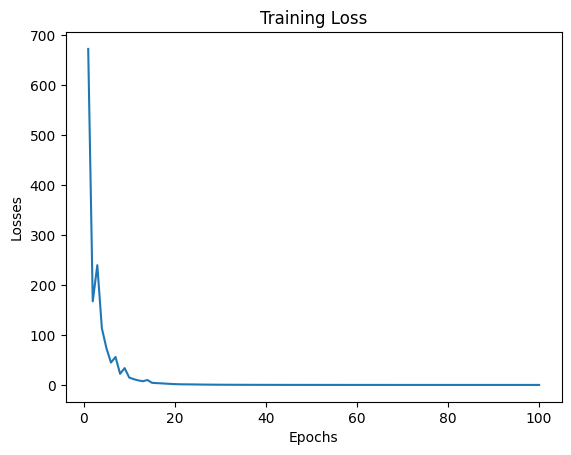

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_tl)+1)

# Plot losses
plt.plot(epochs, history_tl)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

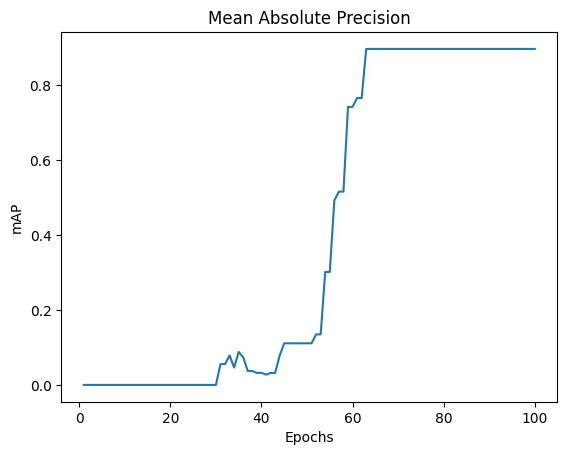

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_ta)+1)

# Plot losses
plt.plot(epochs, history_ta)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Mean Absolute Precision")
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), "YOLOV1_OF_sameT.pth")

# Testing and Evaluation

In [ ]:
# Use the trained model to predict label
pred_boxes, target_boxes = get_bboxes(
    test_loader, model, iou_threshold=0.5, threshold=0.4
)

# Calculate the mean average precision after every epoch/training
mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)

# Print the mean average precision on test dataset
print(f"Mean Average Precision: {mean_avg_prec:.4f}")

Mean Average Precision: 0.8968


# Plot the image with bounding boxes

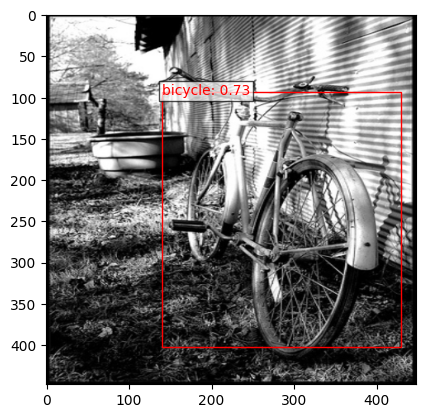

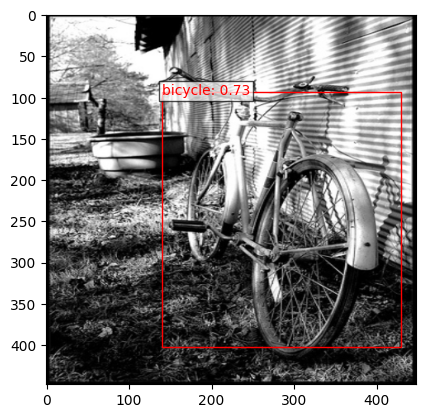

In [ ]:
# For each image
image_path = "/content/drive/MyDrive/8examples/000016.jpg"
image = Image.open(image_path)

# Transform the image
image = transform(image).unsqueeze(0)
image = image.to(device)

# Get bboxes by predicting bboxes for given image
bboxes = cellboxes_to_boxes(model(image))

# Remove multiple bboxes for same object
bboxes = non_max_supression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

# Plot the image with bboxes
plot_image(image[0].permute(1,2,0).to('cpu'), bboxes)

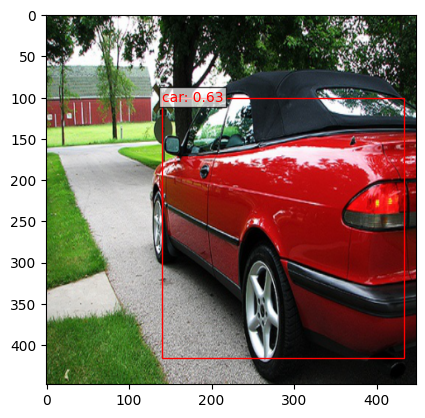

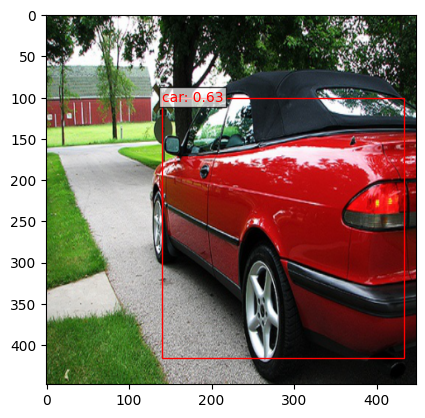

In [ ]:
# For each image
image_path = "/content/drive/MyDrive/8examples/000007.jpg"
image = Image.open(image_path)

# Transform the image
image = transform(image).unsqueeze(0)
image = image.to(device)

# Get bboxes by predicting bboxes for given image
bboxes = cellboxes_to_boxes(model(image))

# Remove multiple bboxes for same object
bboxes = non_max_supression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

# Plot the image with bboxes
plot_image(image[0].permute(1,2,0).to('cpu'), bboxes)